## Merging hourly taxi, weather, and incoming passenger data for 2017

In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
%matplotlib inline

### Reading Aggregated Taxi Data

In [2]:
taxi_hourly_df = pd.read_csv('../clean_data/Aggregated_TaxiData_14-17.csv', index_col=0)

In [3]:
taxi_hourly_df.head()

num_pickups  num_passengers
tpep_pickup_datetime                             
2014-01-01 00:00:00           107           210.0
2014-01-01 01:00:00            34            45.0
2014-01-01 02:00:00            34            70.0
2014-01-01 03:00:00            12            18.0
2014-01-01 04:00:00            25            37.0

In [4]:
taxi_hourly_df.shape

(30425, 2)

In [5]:
taxi_hourly_df.index = pd.DatetimeIndex(taxi_hourly_df.index)

In [6]:
taxi_hourly_df = taxi_hourly_df.drop([pd.Timestamp('2014-11-02 01:00:00'), pd.Timestamp('2015-11-01 01:00:00'), pd.Timestamp('2016-11-06 01:00:00'), pd.Timestamp('2017-03-12 02:00:00')])
taxi_hourly_df.index = taxi_hourly_df.index.tz_localize('America/New_York')

In [7]:
taxi_hourly_df.shape

(30421, 2)

In [8]:
taxi_hourly_df.index.min()

Timestamp('2014-01-01 00:00:00-0500', tz='America/New_York')

In [9]:
taxi_hourly_df.index.max()

Timestamp('2017-06-30 23:00:00-0400', tz='America/New_York')

### Checking Missing Hours from Data and adding them to Datetimeindex. Also created a binary column as Indicator

In [10]:
dateindex = pd.date_range(taxi_hourly_df.index.min(), taxi_hourly_df.index.max(), freq="1H")

In [11]:
taxi_hourly_df = taxi_hourly_df.reindex(dateindex)

In [12]:
taxi_hourly_df.head()

num_pickups  num_passengers
2014-01-01 00:00:00-05:00        107.0           210.0
2014-01-01 01:00:00-05:00         34.0            45.0
2014-01-01 02:00:00-05:00         34.0            70.0
2014-01-01 03:00:00-05:00         12.0            18.0
2014-01-01 04:00:00-05:00         25.0            37.0

In [13]:
taxi_hourly_df["missing_dt"] = np.NaN

In [14]:
taxi_hourly_df.loc[taxi_hourly_df.isnull().all(1) == True, "missing_dt"] = True
taxi_hourly_df.loc[~(taxi_hourly_df.missing_dt == True), "missing_dt"] = False

In [15]:
## Find the number of missing hours
taxi_hourly_df.loc[taxi_hourly_df["missing_dt"] == True, :].shape

(226, 3)

### Preprocessing Missing Values

** a) Missing Hour Values occuring before the 6 months missing data in 2016 **

In [16]:
missing_hours = taxi_hourly_df[(taxi_hourly_df.missing_dt == True)].index.hour

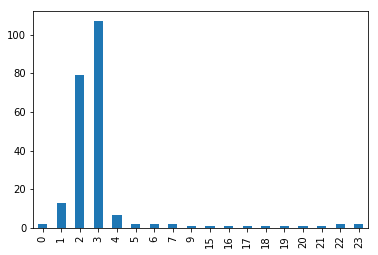

In [17]:
pd.Series(Counter(missing_hours)).plot(kind="bar")

In [18]:
taxi_hourly_df.head()

num_pickups  num_passengers missing_dt
2014-01-01 00:00:00-05:00        107.0           210.0      False
2014-01-01 01:00:00-05:00         34.0            45.0      False
2014-01-01 02:00:00-05:00         34.0            70.0      False
2014-01-01 03:00:00-05:00         12.0            18.0      False
2014-01-01 04:00:00-05:00         25.0            37.0      False

In [19]:
index_missin_hr0to6_before2016 = taxi_hourly_df.loc[(taxi_hourly_df.missing_dt == True) & 
                                                    (taxi_hourly_df.index.hour.isin((0, 1, 2, 3, 4, 5, 6))), :
                                                   ].index

In [21]:
## Number of missing hour values in the first 6 hours
index_missin_hr0to6_before2016.shape

(212,)

In [23]:
## Put those values as 0 and set missing_dt as False
taxi_hourly_df.loc[index_missin_hr0to6_before2016, "num_pickups"] = 0
taxi_hourly_df.loc[index_missin_hr0to6_before2016, "num_passengers"] = 0
taxi_hourly_df.loc[index_missin_hr0to6_before2016, "missing_dt"] = False

In [24]:
## sanity check
taxi_hourly_df.loc[(taxi_hourly_df.missing_dt == True) & 
                    (taxi_hourly_df.index.hour.isin((0, 1, 2, 3, 4, 5, 6))) &
                    (taxi_hourly_df.num_pickups.isnull()) &
                    (taxi_hourly_df.num_passengers.isnull()), :
                   ]

Empty DataFrame
Columns: [num_pickups, num_passengers, missing_dt]
Index: []

In [25]:
taxi_hourly_df.shape

(30647, 3)

** b) Missing Hour Values occuring after the 6 months missing data in 2016 **

In [27]:
index_missin_hrafter6_before2016 = taxi_hourly_df.loc[(taxi_hourly_df.missing_dt == True) & 
                                                    (taxi_hourly_df.index.hour > 6), :
                                                   ].index

In [28]:
index_missin_hrafter6_before2016

DatetimeIndex(['2015-01-26 22:00:00-05:00', '2015-01-26 23:00:00-05:00',
               '2015-01-27 07:00:00-05:00', '2016-01-23 07:00:00-05:00',
               '2016-01-23 09:00:00-05:00', '2016-01-23 15:00:00-05:00',
               '2016-01-23 16:00:00-05:00', '2016-01-23 17:00:00-05:00',
               '2016-01-23 18:00:00-05:00', '2016-01-23 19:00:00-05:00',
               '2016-01-23 20:00:00-05:00', '2016-01-23 21:00:00-05:00',
               '2016-01-23 22:00:00-05:00', '2016-01-23 23:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', freq=None)

In [29]:
groupby_imputation = taxi_hourly_df.groupby([taxi_hourly_df.index.month, taxi_hourly_df.index.dayofweek, taxi_hourly_df.index.hour]).mean()

In [30]:
groupby_imputation.head()

num_pickups  num_passengers
1 0 0   310.941176      511.058824
    1    77.352941      130.941176
    2    39.000000       68.800000
    3    19.176471       32.600000
    4    12.352941       17.588235

In [31]:
idxslice = pd.IndexSlice

In [32]:
# groupby_imputation.loc[idxslice[index_missin_hrafter6_before2016[-1].month, 
#                            index_missin_hrafter6_before2016[-1].dayofweek, 
#                            index_missin_hrafter6_before2016[-1].hour], :]

In [33]:
for idx in index_missin_hrafter6_before2016:
    taxi_hourly_df.loc[idx, "num_pickups"] = groupby_imputation.loc[idxslice[idx.month, idx.dayofweek, idx.hour], 
                                                                    "num_pickups"]
    taxi_hourly_df.loc[idx, "num_passengers"] = groupby_imputation.loc[idxslice[idx.month, idx.dayofweek, idx.hour], 
                                                                    "num_passengers"]
    taxi_hourly_df.loc[idx, "missing_dt"] = False

In [34]:
taxi_hourly_df.loc[index_missin_hrafter6_before2016, :] 

num_pickups  num_passengers missing_dt
2015-01-26 22:00:00-05:00   662.562500     1119.625000      False
2015-01-26 23:00:00-05:00   577.562500      960.000000      False
2015-01-27 07:00:00-05:00   253.250000      417.500000      False
2016-01-23 07:00:00-05:00    36.235294       60.705882      False
2016-01-23 09:00:00-05:00   189.294118      330.529412      False
2016-01-23 15:00:00-05:00   358.235294      618.705882      False
2016-01-23 16:00:00-05:00   316.235294      555.882353      False
2016-01-23 17:00:00-05:00   368.470588      646.235294      False
2016-01-23 18:00:00-05:00   318.941176      560.764706      False
2016-01-23 19:00:00-05:00   305.941176      538.647059      False
2016-01-23 20:00:00-05:00   278.411765      486.882353      False
2016-01-23 21:00:00-05:00   266.176471      458.352941      False
2016-01-23 22:00:00-05:00   304.588235      527.294118      False
2016-01-23 23:00:00-05:00   310.705882      535.000000      False

** c) Final check for missing values **

In [35]:
index_missing = taxi_hourly_df.loc[(taxi_hourly_df.missing_dt == True) & 
#                                                    (taxi_hourly_df.index < "2016-07-01") &
                                                    (taxi_hourly_df.num_passengers.isnull()) , :
                                                   ].index

In [36]:
assert len(index_missing) == 0# all missing values before last 6 months of 2016 filled

In [37]:
taxi_hourly_df.index.min()

Timestamp('2014-01-01 00:00:00-0500', tz='America/New_York', freq='H')

In [38]:
taxi_hourly_df.index.max()

Timestamp('2017-06-30 23:00:00-0400', tz='America/New_York', freq='H')

In [39]:
len(taxi_hourly_df.index.unique())

30647

In [42]:
## sanity check
taxi_hourly_df.loc[index_missing, :]

Empty DataFrame
Columns: [num_pickups, num_passengers, missing_dt]
Index: []

### Weather Data

In [43]:
def clean_weather(path):
    weather_df = pd.read_csv(path)
    weather_df["date"] = pd.DatetimeIndex(pd.to_datetime(weather_df.dt, unit="s")) \
                    .tz_localize('UTC').tz_convert('America/New_York')
    
    weather_df.drop(["dt", "dt_iso", "city_id", "city_name", "lat", "lon", "weather_icon", "grnd_level", \
                 "sea_level", "clouds_all", "weather_id", "rain_1h", "rain_3h", "rain_24h", \
                 "rain_today", "snow_1h", "snow_3h", "snow_24h", "snow_today", "wind_deg", "pressure"], 
                    axis=1, inplace=True)
    return weather_df

In [44]:
weather_df = clean_weather("../clean_data/weather_NY.csv")

In [45]:
weather_df.shape

(49811, 8)

In [46]:
Counter(weather_df["weather_main"].values)

Counter({'Clear': 10342,
         'Clouds': 16999,
         'Drizzle': 1455,
         'Dust': 22,
         'Fog': 1746,
         'Haze': 1188,
         'Mist': 8203,
         'Rain': 8347,
         'Sand': 1,
         'Smoke': 12,
         'Snow': 952,
         'Squall': 6,
         'Thunderstorm': 538})

In [47]:
weather_df.groupby(["weather_main", "weather_description"]).sum()

temp     temp_min  \
weather_main weather_description                                             
Clear        Sky is Clear                         1284365.163  1278112.133   
             sky is clear                         1663573.659  1646978.319   
Clouds       broken clouds                        1657507.303  1644118.223   
             few clouds                            844677.983   838056.193   
             overcast clouds                      1154702.143  1146811.073   
             scattered clouds                     1204912.368  1195098.908   
Drizzle      drizzle                               117887.490   117064.930   
             heavy intensity drizzle                 7677.670     7623.940   
             light intensity drizzle               288333.160   286486.630   
Dust         Sand/Dust Whirls                         297.230      295.150   
             dust                                    6251.140     6184.930   
Fog          fog                                   497282.520   492109.180   
Haze         haze                                  342274.810   339330.110   
Mist         mist                                 2348599.460  2327835.640   
Rain         freezing rain                           6563.330     6482.930   
             heavy intensity rain                  218015.147   216412.057   
             light intensity shower rain              287.560      284.150   
             light rain                           1623736.051  1611680.291   
             moderate rain                         531663.792   527888.362   
             shower rain                              280.070      279.150   
             very heavy rain                        19647.100    19495.950   
Sand         sand                                     285.510      283.150   
Smoke        smoke                                   3490.280     3460.480   
Snow         heavy snow                             74836.210    74372.050   
             light rain and snow                     9341.940     9291.220   
             light snow                            133332.380   132234.850   
             rain and snow                            275.320      272.590   
             sleet                                    274.940      274.150   
             snow                                   41268.060    40988.550   
Squall       SQUALLS                                 1732.280     1716.680   
Thunderstorm heavy thunderstorm                       595.750      586.300   
             proximity thunderstorm                 61795.880    61182.660   
             proximity thunderstorm with drizzle      277.980      277.150   
             proximity thunderstorm with rain        1459.840     1451.870   
             thunderstorm                           40888.410    40462.720   
             thunderstorm with heavy rain           14335.080    14212.450   
             thunderstorm with light drizzle         1180.800     1171.040   
             thunderstorm with light rain           21827.840    21600.990   
             thunderstorm with rain                 16109.710    15977.010   

                                                     temp_max  humidity  \
weather_main weather_description                                          
Clear        Sky is Clear                         1291340.753    301885   
             sky is clear                         1678705.549    323948   
Clouds       broken clouds                        1669387.133    321296   
             few clouds                            850798.663    158408   
             overcast clouds                      1161761.023    257026   
             scattered clouds                     1213764.598    224302   
Drizzle      drizzle                               118646.140     36493   
             heavy intensity drizzle                 7730.940      2429   
             light intensity drizzle               290090.480     86847   
Dust         Sand/Dust Whirls    

** Handling Dust, Sand, Smoke and Squall Weather Types **

In [48]:
## set these weather conditions to NaN and ffill them with previous hours data
weather_df.loc[weather_df["weather_main"].isin(["Dust", "Sand", "Smoke", "Squall"]), ["weather_main", "weather_description"]] = np.NaN
weather_df = weather_df.fillna(method="ffill")

In [49]:
weather_df.shape

(49811, 8)

** Combining Weather Types **

In [50]:
Counter(weather_df["weather_main"].values)

Counter({'Clear': 10347,
         'Clouds': 17016,
         'Drizzle': 1455,
         'Fog': 1747,
         'Haze': 1197,
         'Mist': 8207,
         'Rain': 8349,
         'Snow': 952,
         'Thunderstorm': 541})

In [51]:
# Lowercase Weather Types
weather_df["weather_main"] = weather_df.weather_main.str.lower()
weather_df["weather_description"] = weather_df.weather_description.str.lower()

In [52]:
# Handle Drizzle Weather Type
weather_df["weather_main"] = weather_df.weather_main.str.replace("drizzle", "rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("drizzle", "light rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("heavy intensity drizzle", "moderate rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("light intensity drizzle", "light rain")

In [53]:
# Handle Drizzle and Mist Weather Type - Combine to Fog
weather_df["weather_main"] = weather_df.weather_main.str.replace("haze", "fog")
weather_df["weather_description"] = weather_df.weather_description.str.replace("haze", "fog")
weather_df["weather_main"] = weather_df.weather_main.str.replace("mist", "fog")
weather_df["weather_description"] = weather_df.weather_description.str.replace("mist", "fog")

In [54]:
# Handle Rain Weather Type
weather_df["weather_description"] = weather_df.weather_description.str.replace("light intensity light rain", "light rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("light intensity shower rain", "light rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("heavy intensity light rain", "light rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("shower rain", "light rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("very heavy rain", "heavy intensity rain")
weather_df["weather_description"] = weather_df.weather_description.str.replace("freezing rain", "heavy intensity rain")

In [55]:
# Handle Snow Weather Type
weather_df["weather_description"] = weather_df.weather_description.str.replace("light rain and snow", "light snow")
weather_df["weather_description"] = weather_df.weather_description.str.replace("rain and snow", "snow")
weather_df["weather_description"] = weather_df.weather_description.str.replace("sleet", "snow")

In [56]:
# Handling Thunderstorm Data Type
weather_df["weather_description"] = weather_df.weather_description.str.replace("proximity thunderstorm with light rain", "proximity thunderstorm")
weather_df["weather_description"] = weather_df.weather_description.str.replace("proximity thunderstorm with rain", "proximity thunderstorm")
weather_df["weather_description"] = weather_df.weather_description.str.replace("proximity thunderstorm with light rain", "proximity thunderstorm")
weather_df["weather_description"] = weather_df.weather_description.str.replace("thunderstorm with heavy rain", "thunderstorm")
weather_df["weather_description"] = weather_df.weather_description.str.replace("thunderstorm with light light rain", "thunderstorm")
weather_df["weather_description"] = weather_df.weather_description.str.replace("thunderstorm with light rain", "thunderstorm")
weather_df["weather_description"] = weather_df.weather_description.str.replace("thunderstorm with rain", "thunderstorm")
weather_df["weather_description"] = weather_df.weather_description.str.replace("heavy thunderstorm", "thunderstorm")

In [57]:
weather_df.groupby(["weather_main", "weather_description"]).sum()

temp      temp_min      temp_max  \
weather_main weather_description                                               
clear        sky is clear            2949387.302  2.926526e+06  2.971507e+06   
clouds       broken clouds           1659275.563  1.645866e+06  1.671173e+06   
             few clouds               844677.983  8.380562e+05  8.507987e+05   
             overcast clouds         1155280.863  1.147378e+06  1.162345e+06   
             scattered clouds        1207567.358  1.197728e+06  1.216451e+06   
fog          fog                     3192304.080  3.163393e+06  3.219729e+06   
rain         heavy intensity rain     244225.577  2.423909e+05  2.460286e+05   
             light rain              2038774.991  2.023985e+06  2.052515e+06   
             moderate rain            531663.792  5.278884e+05  5.352082e+05   
snow         heavy snow                74836.210  7.437205e+04  7.528951e+04   
             light snow               142674.320  1.415261e+05  1.437471e+05   
             snow                      41818.320  4.153529e+04  4.210542e+04   
thunderstorm proximity thunderstorm    63533.700  6.291168e+04  6.407977e+04   
             thunderstorm              95823.300  9.488663e+04  9.667105e+04   

                                     humidity  wind_speed  
weather_main weather_description                           
clear        sky is clear              626091       28324  
clouds       broken clouds             321635       21569  
             few clouds                158408       10680  
             overcast clouds           257150       13777  
             scattered clouds          224708       15379  
fog          fog                       929384       31547  
rain         heavy intensity rain       68608        2834  
             light rain                558601       24097  
             moderate rain             154788        6714  
snow         heavy snow                 19230        1551  
             light snow                 37653        2250  
             snow                       12274         823  
thunderstorm proximity thunderstorm     16377         718  
             thunderstorm               25127        1217

In [58]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49811 entries, 0 to 49810
Data columns (total 8 columns):
temp                   49811 non-null float64
temp_min               49811 non-null float64
temp_max               49811 non-null float64
humidity               49811 non-null int64
wind_speed             49811 non-null int64
weather_main           49811 non-null object
weather_description    49811 non-null object
date                   49811 non-null datetime64[ns, America/New_York]
dtypes: datetime64[ns, America/New_York](1), float64(3), int64(2), object(2)
memory usage: 3.0+ MB


In [59]:
# weather_df["weather_main"] = weather_df.weather_main.astype("category")
# weather_df["weather_description"] = weather_df.weather_description.astype("category")

In [60]:
#weather_df.weather_description.cat.codes
#weather_df.weather_description.cat.categories

In [61]:
# weather_df.groupby("date").agg({"temp":"mean", "temp_min":"mean", "temp_max":"mean", "humidity": "mean",
#                                 "wind_speed":"mean", "weather_main" : lambda x: getExtreme_WeatherMain(x),
#                                 "weather_description" : lambda x : getExtreme_WeatherDesc(x) })

In [62]:
# For every hour, if extreme weather type (thunderstorm, snow, rain or fog), return that, else just return the first 
# wether type reported in that hour

# def getExtreme_WeatherMain(vals):
#     if "thunderstorm" in vals.values:
#         return "thunderstorm"
#     elif "snow" in vals.values:
#         return "snow"
#     elif "rain" in vals.values:
#         return "rain"
#     elif "fog" in vals.values:
#         return "fog"
#     else:
#         return vals.values[0]
    
# def getExtreme_WeatherDesc(vals):
#     if "thunderstorm" in vals.values:
#         return "thunderstorm"
#     elif "proximity thunderstorm" in vals.values:
#         return "proximity thunderstorm"
#     elif "heavy snow" in vals.values:
#         return "heavy snow"
#     elif "snow" in vals.values:
#         return "snow"
#     elif "light snow" in vals.values:
#         return "light snow"
#     elif "freezing rain" in vals.values:
#         return "freezing rain"
#     elif "heavy intensity rain" in vals.values:
#         return "heavy intensity rain"
#     elif "moderate rain" in vals.values:
#         return "moderate rain"
#     elif "light rain" in vals.values:
#         return "light rain"
#     elif "fog" in vals.values:
#         return "fog"
#     else:
#         return vals.values[0]

In [63]:
# data_1 = {'date' : ['2014-01-01 00:00:00-05:00', '2014-01-01 00:00:00-05:00', '2014-01-01 00:00:00-05:00'],
#           'weather_main' : ["fog", "clouds", "snow"],
#           'weather_description' : ["fog", "broken clouds", "light snow"]}
# df_1 = pd.DataFrame(data_1)
# df_1
# df_1.groupby("date").agg({"weather_main" : lambda x: getExtreme_WeatherMain(x),
#                           "weather_description" : lambda x : getExtreme_WeatherDesc(x)})

In [64]:
def concat_weather_types(vals):
    return ",".join(list(set(vals)))

In [65]:
weather_df = weather_df.groupby("date").agg({"temp":"mean", "temp_min":"mean", "temp_max":"mean", "humidity": "mean",
                                "wind_speed":"mean", "weather_main" : lambda x: concat_weather_types(x),
                                "weather_description" : lambda x : concat_weather_types(x) })

In [66]:
#weather_df

In [67]:
#weather_df.groupby(["weather_main", "weather_description"]).sum()

In [68]:
weather_df = weather_df.reindex(taxi_hourly_df.index)

In [69]:
## Filled in missing hours with the data available for previous hours
weather_df = weather_df.fillna(method = "ffill")

In [70]:
#weather_df[weather_df.weather_main.isnull()]

### Merge Taxi and Weather Data

In [71]:
taxi_weather_df = pd.concat([taxi_hourly_df, weather_df], axis=1)

In [72]:
taxi_weather_df.head()

num_pickups  num_passengers missing_dt    temp  \
2014-01-01 00:00:00-05:00        107.0           210.0      False  269.27   
2014-01-01 01:00:00-05:00         34.0            45.0      False  268.90   
2014-01-01 02:00:00-05:00         34.0            70.0      False  268.48   
2014-01-01 03:00:00-05:00         12.0            18.0      False  268.33   
2014-01-01 04:00:00-05:00         25.0            37.0      False  268.10   

                           temp_min  temp_max  humidity  wind_speed  \
2014-01-01 00:00:00-05:00    267.59    270.93      80.0         3.0   
2014-01-01 01:00:00-05:00    267.04    270.93      80.0         2.0   
2014-01-01 02:00:00-05:00    266.48    270.37      57.0         3.0   
2014-01-01 03:00:00-05:00    265.93    270.37      80.0         3.0   
2014-01-01 04:00:00-05:00    265.37    270.37      80.0         3.0   

                          weather_main weather_description  
2014-01-01 00:00:00-05:00        clear        sky is clear  
2014-01-01 01:00:00-05:00        clear        sky is clear  
2014-01-01 02:00:00-05:00        clear        sky is clear  
2014-01-01 03:00:00-05:00        clear        sky is clear  
2014-01-01 04:00:00-05:00        clear        sky is clear

In [73]:
taxi_weather_df.shape

(30647, 10)

### Passenger seat data

In [74]:
def clean_seats(path):
    seats_per_hour = pd.read_csv(path)
    seats_per_hour.columns = ['Time', 'Passengers']
    seats_per_hour["Time"] = pd.DatetimeIndex(seats_per_hour.Time)
    seats_per_hour.set_index("Time", inplace = True)

    #To get rid of errors surrounding daylight savings time. All of taxi pickups and passenger counts are NaNs for these times
    seats_per_hour = seats_per_hour.drop([pd.Timestamp('2014-03-09 02:00:00'), pd.Timestamp('2014-11-02 01:00:00'), pd.Timestamp('2015-03-08 02:00:00'), pd.Timestamp('2015-11-01 01:00:00'), pd.Timestamp('2016-03-13 02:00:00'), pd.Timestamp('2016-11-06 01:00:00'), pd.Timestamp('2017-03-12 02:00:00')])
    seats_per_hour.index = seats_per_hour.index.tz_localize('America/New_York')
    return seats_per_hour

In [75]:
seats_per_hour = clean_seats('../clean_data/passengers_per_hour_since_2014.csv')

In [76]:
seats_per_hour = seats_per_hour.reindex(taxi_weather_df.index)

In [77]:
seats_per_hour.fillna(0, inplace=True)

### Merging all dataframes

In [78]:
merged_df = pd.concat([taxi_weather_df, seats_per_hour], axis=1)

In [79]:
merged_df.shape

(30647, 11)

In [80]:
merged_df.head()

num_pickups  num_passengers missing_dt    temp  \
2014-01-01 00:00:00-05:00        107.0           210.0      False  269.27   
2014-01-01 01:00:00-05:00         34.0            45.0      False  268.90   
2014-01-01 02:00:00-05:00         34.0            70.0      False  268.48   
2014-01-01 03:00:00-05:00         12.0            18.0      False  268.33   
2014-01-01 04:00:00-05:00         25.0            37.0      False  268.10   

                           temp_min  temp_max  humidity  wind_speed  \
2014-01-01 00:00:00-05:00    267.59    270.93      80.0         3.0   
2014-01-01 01:00:00-05:00    267.04    270.93      80.0         2.0   
2014-01-01 02:00:00-05:00    266.48    270.37      57.0         3.0   
2014-01-01 03:00:00-05:00    265.93    270.37      80.0         3.0   
2014-01-01 04:00:00-05:00    265.37    270.37      80.0         3.0   

                          weather_main weather_description  Passengers  
2014-01-01 00:00:00-05:00        clear        sky is clear       108.0  
2014-01-01 01:00:00-05:00        clear        sky is clear         0.0  
2014-01-01 02:00:00-05:00        clear        sky is clear         0.0  
2014-01-01 03:00:00-05:00        clear        sky is clear         0.0  
2014-01-01 04:00:00-05:00        clear        sky is clear         0.0

In [81]:
merged_df['Month'] = merged_df.index.month

In [82]:
merged_df['Hour'] = merged_df.index.hour

In [83]:
merged_df['Day'] = merged_df.index.dayofweek

In [84]:
merged_df.head()

num_pickups  num_passengers missing_dt    temp  \
2014-01-01 00:00:00-05:00        107.0           210.0      False  269.27   
2014-01-01 01:00:00-05:00         34.0            45.0      False  268.90   
2014-01-01 02:00:00-05:00         34.0            70.0      False  268.48   
2014-01-01 03:00:00-05:00         12.0            18.0      False  268.33   
2014-01-01 04:00:00-05:00         25.0            37.0      False  268.10   

                           temp_min  temp_max  humidity  wind_speed  \
2014-01-01 00:00:00-05:00    267.59    270.93      80.0         3.0   
2014-01-01 01:00:00-05:00    267.04    270.93      80.0         2.0   
2014-01-01 02:00:00-05:00    266.48    270.37      57.0         3.0   
2014-01-01 03:00:00-05:00    265.93    270.37      80.0         3.0   
2014-01-01 04:00:00-05:00    265.37    270.37      80.0         3.0   

                          weather_main weather_description  Passengers  Month  \
2014-01-01 00:00:00-05:00        clear        sky is clear       108.0      1   
2014-01-01 01:00:00-05:00        clear        sky is clear         0.0      1   
2014-01-01 02:00:00-05:00        clear        sky is clear         0.0      1   
2014-01-01 03:00:00-05:00        clear        sky is clear         0.0      1   
2014-01-01 04:00:00-05:00        clear        sky is clear         0.0      1   

                           Hour  Day  
2014-01-01 00:00:00-05:00     0    2  
2014-01-01 01:00:00-05:00     1    2  
2014-01-01 02:00:00-05:00     2    2  
2014-01-01 03:00:00-05:00     3    2  
2014-01-01 04:00:00-05:00     4    2

### Adding Federal Calendar Holidays

In [85]:
dr = pd.to_datetime(pd.to_datetime(merged_df.index.date))

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

merged_df['holiday'] = dr.isin(holidays)

### Precipitation Data

In [86]:
precipitation = pd.read_csv('../clean_data/hourly_precipitation.csv')

In [87]:
prec_group = precipitation.groupby(['valid']).agg({"precip_in" : np.max})

In [88]:
prec_group.index = pd.DatetimeIndex(prec_group.index)
prec_group = prec_group.drop([pd.Timestamp('2014-11-02 01:00:00'), pd.Timestamp('2015-11-01 01:00:00'), pd.Timestamp('2016-11-06 01:00:00')])
prec_group.index = prec_group.index.tz_localize('America/New_York')

In [89]:
prec_group = prec_group.reindex(taxi_weather_df.index)

In [90]:
prec_group.head()

precip_in
2014-01-01 00:00:00-05:00        NaN
2014-01-01 01:00:00-05:00        0.0
2014-01-01 02:00:00-05:00        0.0
2014-01-01 03:00:00-05:00        0.0
2014-01-01 04:00:00-05:00        0.0

In [91]:
prec_group.precip_in.fillna(method='bfill', inplace=True)

In [92]:
merged_df_prec = pd.concat([merged_df, prec_group], axis=1)

### Combining Flight Delays

In [93]:
flight_delays = pd.read_csv("../clean_data/delays_per_hour.csv")

In [94]:
flight_delays.head()

ARR_DATETIME  Avg_Delay_Arriving  Avg_Delay_Departing
0  2014-01-01 03:00:00               291.0                  NaN
1  2014-01-01 04:00:00                 NaN                  NaN
2  2014-01-01 05:00:00                 NaN             0.000000
3  2014-01-01 06:00:00                 NaN             2.166667
4  2014-01-01 07:00:00                 0.0             1.529412

In [95]:
flight_delays["ARR_DATETIME"] = pd.DatetimeIndex(flight_delays.ARR_DATETIME)
flight_delays.set_index("ARR_DATETIME", inplace=True)

#To get rid of errors surrounding daylight savings time. All of taxi pickups and passenger counts are NaNs for these times
flight_delays = flight_delays.drop([pd.Timestamp('2014-03-09 02:00:00'), pd.Timestamp('2014-11-02 01:00:00'), pd.Timestamp('2015-03-08 02:00:00'), pd.Timestamp('2015-11-01 01:00:00'), pd.Timestamp('2016-03-13 02:00:00'), pd.Timestamp('2016-11-06 01:00:00'), pd.Timestamp('2017-03-12 02:00:00')])
flight_delays.index = flight_delays.index.tz_localize('America/New_York')

In [96]:
## Always fill values after reindex
flight_delays = flight_delays.reindex(taxi_hourly_df.index)
flight_delays.fillna(0, inplace=True)

In [97]:
merged_df_flightdelays = pd.concat([merged_df_prec, flight_delays], axis=1)

### Combining Flight Cancellations

In [98]:
flight_cancels = pd.read_csv("../clean_data/cancelled_flights_per_hour.csv")

In [99]:
flight_cancels.head()

SCHED_DEP_DATETIME  Cancelled_Arriving_Flights  \
0  2014-01-01 06:00:00                           1   
1  2014-01-01 07:00:00                           1   
2  2014-01-01 08:00:00                           0   
3  2014-01-01 09:00:00                           0   
4  2014-01-01 10:00:00                           0   

   Cancelled_Departing_Flights  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN

In [100]:
flight_cancels["SCHED_DEP_DATETIME"] = pd.DatetimeIndex(flight_cancels.SCHED_DEP_DATETIME)
flight_cancels.set_index("SCHED_DEP_DATETIME", inplace=True)

#To get rid of errors surrounding daylight savings time. All of taxi pickups and passenger counts are NaNs for these times
flight_cancels = flight_cancels.drop([pd.Timestamp('2014-03-09 02:00:00'), pd.Timestamp('2014-11-02 01:00:00'), pd.Timestamp('2015-03-08 02:00:00'), pd.Timestamp('2015-11-01 01:00:00'), pd.Timestamp('2016-03-13 02:00:00'), pd.Timestamp('2016-11-06 01:00:00'), pd.Timestamp('2017-03-12 02:00:00')])
flight_cancels.index = flight_cancels.index.tz_localize('America/New_York')

In [101]:
## Always fill values after reindex
flight_cancels = flight_cancels.reindex(taxi_hourly_df.index)
flight_cancels.fillna(0, inplace=True)

In [102]:
merged_df_flight_cancels = pd.concat([merged_df_flightdelays, flight_cancels], axis=1)

In [103]:
merged_df_flight_cancels.head()

num_pickups  num_passengers missing_dt    temp  \
2014-01-01 00:00:00-05:00        107.0           210.0      False  269.27   
2014-01-01 01:00:00-05:00         34.0            45.0      False  268.90   
2014-01-01 02:00:00-05:00         34.0            70.0      False  268.48   
2014-01-01 03:00:00-05:00         12.0            18.0      False  268.33   
2014-01-01 04:00:00-05:00         25.0            37.0      False  268.10   

                           temp_min  temp_max  humidity  wind_speed  \
2014-01-01 00:00:00-05:00    267.59    270.93      80.0         3.0   
2014-01-01 01:00:00-05:00    267.04    270.93      80.0         2.0   
2014-01-01 02:00:00-05:00    266.48    270.37      57.0         3.0   
2014-01-01 03:00:00-05:00    265.93    270.37      80.0         3.0   
2014-01-01 04:00:00-05:00    265.37    270.37      80.0         3.0   

                          weather_main weather_description  Passengers  Month  \
2014-01-01 00:00:00-05:00        clear        sky is clear       108.0      1   
2014-01-01 01:00:00-05:00        clear        sky is clear         0.0      1   
2014-01-01 02:00:00-05:00        clear        sky is clear         0.0      1   
2014-01-01 03:00:00-05:00        clear        sky is clear         0.0      1   
2014-01-01 04:00:00-05:00        clear        sky is clear         0.0      1   

                           Hour  Day  holiday  precip_in  Avg_Delay_Arriving  \
2014-01-01 00:00:00-05:00     0    2     True        0.0                 0.0   
2014-01-01 01:00:00-05:00     1    2     True        0.0                 0.0   
2014-01-01 02:00:00-05:00     2    2     True        0.0                 0.0   
2014-01-01 03:00:00-05:00     3    2     True        0.0               291.0   
2014-01-01 04:00:00-05:00     4    2     True        0.0                 0.0   

                           Avg_Delay_Departing  Cancelled_Arriving_Flights  \
2014-01-01 00:00:00-05:00                  0.0                         0.0   
2014-01-01 01:00:00-05:00                  0.0                         0.0   
2014-01-01 02:00:00-05:00                  0.0                         0.0   
2014-01-01 03:00:00-05:00                  0.0                         0.0   
2014-01-01 04:00:00-05:00                  0.0                         0.0   

                           Cancelled_Departing_Flights  
2014-01-01 00:00:00-05:00                          0.0  
2014-01-01 01:00:00-05:00                          0.0  
2014-01-01 02:00:00-05:00                          0.0  
2014-01-01 03:00:00-05:00                          0.0  
2014-01-01 04:00:00-05:00                          0.0

### Generating Final Merged Model File

In [104]:
merged_df_flight_cancels.to_csv("../clean_data/FinalData_for_Models.csv")

---